# Week 3 — Churn Prediction for StreamWorks Media

**Dataset:** `streamworks_user_data.csv`  
**Goal:** Understand churn patterns and build predictive models (Logistic Regression + Linear Regression) with clear business insights.


In [1]:
# ✅ Setup
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from pathlib import Path
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    mean_squared_error,
    r2_score,
)

from scipy.stats import chi2_contingency, ttest_ind

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
# 1) Load the Data
# Ensure the file 'streamworks_user_data.csv' is uploaded to your environment

try:
    df = pd.read_csv("streamworks_user_data.csv")
    print("✅ Data loaded successfully!")
except FileNotFoundError:
    raise FileNotFoundError("❌ File not found. Please upload 'streamworks_user_data.csv'")

# Preserve a raw copy for statistical analysis
df_raw = df.copy()

✅ Data loaded successfully!


In [3]:
# 2) Quick exploration

print("\n--- Dataset Shape ---")
print(df.shape)

print("\n--- First 5 Rows ---")
display(df.head())

print("\n--- Data Info ---")
df.info()

print("\n--- Descriptive Statistics ---")
display(df.describe(include="all").T)


--- Dataset Shape ---
(1500, 14)

--- First 5 Rows ---


,user_id,age,gender,signup_date,last_active_date,country,subscription_type,average_watch_hours,mobile_app_usage_pct,complaints_raised,received_promotions,referred_by_friend,is_churned,monthly_fee
0,1001.0,56.0,Other,02-04-25,13-07-25,France,Standard,42.6,77.4,1.0,No,No,1.0,10.99
1,1002.0,69.0,Male,02-01-23,13-07-25,India,Basic,65.3,98.0,4.0,No,Yes,1.0,5.99
2,1003.0,46.0,Male,21-08-22,13-07-25,UK,Premium,40.1,47.8,0.0,No,Yes,1.0,13.99
3,1004.0,32.0,Other,14-09-23,13-07-25,Germany,Premium,5.8,53.2,1.0,Yes,Yes,1.0,13.99
4,1005.0,60.0,Female,29-07-23,13-07-25,India,Standard,32.7,16.8,5.0,No,Yes,0.0,9.99



--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               1498 non-null   float64
 1   age                   1497 non-null   float64
 2   gender                1499 non-null   object 
 3   signup_date           1498 non-null   object 
 4   last_active_date      1498 non-null   object 
 5   country               1497 non-null   object 
 6   subscription_type     1497 non-null   object 
 7   average_watch_hours   1496 non-null   float64
 8   mobile_app_usage_pct  1498 non-null   float64
 9   complaints_raised     1497 non-null   float64
 10  received_promotions   1497 non-null   object 
 11  referred_by_friend    1497 non-null   object 
 12  is_churned            1499 non-null   float64
 13  monthly_fee           1355 non-null   float64
dtypes: float64(7), object(7)
memory usage: 164.2+ KB

---

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
user_id,1498.0,NaN,NaN,NaN,1750.871829,433.06098,1001.0,1376.25,1750.5,2125.75,2500.0
age,1497.0,NaN,NaN,NaN,43.738811,15.08392,18.0,31.0,44.0,56.0,69.0
gender,1499,3,Female,510,NaN,NaN,NaN,NaN,NaN,NaN,NaN
signup_date,1498,819,19-09-23,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last_active_date,1498,1,13-07-25,1498,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,1497,6,Canada,262,NaN,NaN,NaN,NaN,NaN,NaN,NaN
subscription_type,1497,3,Basic,505,NaN,NaN,NaN,NaN,NaN,NaN,NaN
average_watch_hours,1496.0,NaN,NaN,NaN,39.903342,22.978288,0.5,19.45,40.3,59.8,79.9
mobile_app_usage_pct,1498.0,NaN,NaN,NaN,51.414419,28.580117,0.0,27.1,52.7,76.2,100.0
complaints_raised,1497.0,NaN,NaN,NaN,2.49833,1.706829,0.0,1.0,2.0,4.0,5.0


In [4]:
# 3) Missing values
print("\n--- Missing Values Check ---")
df.isnull().sum().sort_values(ascending=False)


--- Missing Values Check ---


,0
monthly_fee,145
average_watch_hours,4
subscription_type,3
complaints_raised,3
age,3
country,3
referred_by_friend,3
received_promotions,3
signup_date,2
user_id,2


In [5]:
# 4) Key distributions
for col in ["gender", "subscription_type", "country", "received_promotions", "referred_by_friend", "is_churned"]:
    if col in df.columns:
        print("\n", col)
        print(df[col].value_counts(dropna=False))



 gender
gender
Female    510
Other     506
Male      483
NaN         1
Name: count, dtype: int64

 subscription_type
subscription_type
Basic       505
Premium     499
Standard    493
NaN           3
Name: count, dtype: int64

 country
country
Canada     262
India      259
France     254
Germany    246
UK         241
USA        235
NaN          3
Name: count, dtype: int64

 received_promotions
received_promotions
No     763
Yes    734
NaN      3
Name: count, dtype: int64

 referred_by_friend
referred_by_friend
Yes    752
No     745
NaN      3
Name: count, dtype: int64

 is_churned
is_churned
0.0    1148
1.0     351
NaN       1
Name: count, dtype: int64


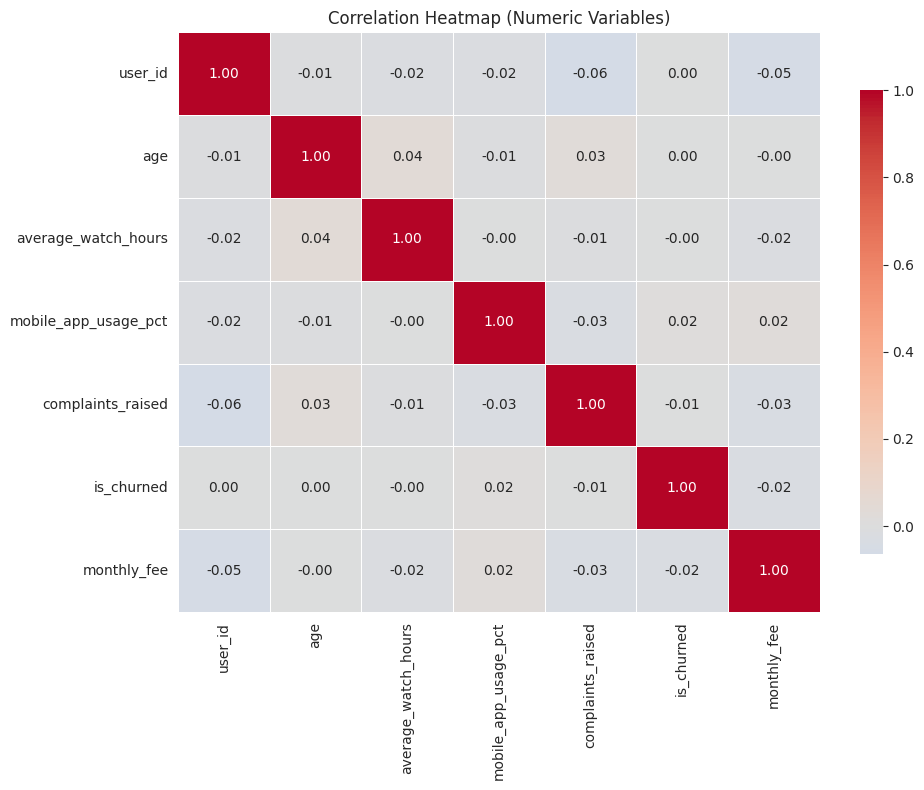

,user_id,age,average_watch_hours,mobile_app_usage_pct,complaints_raised,is_churned,monthly_fee
user_id,1.000000,-0.010213,-0.019042,-0.021341,-0.063852,0.001454,-0.054005
age,-0.010213,1.000000,0.036806,-0.009936,0.027707,0.002173,-0.001641
average_watch_hours,-0.019042,0.036806,1.000000,-0.004899,-0.013767,-0.004681,-0.021213
mobile_app_usage_pct,-0.021341,-0.009936,-0.004899,1.000000,-0.028562,0.016353,0.022061
complaints_raised,-0.063852,0.027707,-0.013767,-0.028562,1.000000,-0.005118,-0.033150
is_churned,0.001454,0.002173,-0.004681,0.016353,-0.005118,1.000000,-0.023976
monthly_fee,-0.054005,-0.001641,-0.021213,0.022061,-0.033150,-0.023976,1.000000


In [6]:
# 5) Correlation matrix (Improved Visual)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[num_cols].corr()

plt.figure(figsize=(10, 8))

# Using 'coolwarm' (Blue=Negative, Red=Positive)
sns.heatmap(
    corr,
    annot=True,       # Show the numbers
    fmt=".2f",        # 2 decimal places
    cmap="coolwarm",  # Lighter, diverging color scheme
    center=0,         # Makes 0 white (neutral)
    linewidths=0.5,   # Adds white lines between squares
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Heatmap (Numeric Variables)")
plt.tight_layout()
plt.show()

corr


## 3. Data Cleaning & Preparation

We will:
- Convert date columns to `datetime`
- Create `tenure_days` and `is_loyal`
- Handle missing values
- Encode categorical variables
- Build a clean modeling table (no leakage, no IDs)


In [7]:
# Convert dates
df["signup_date"] = pd.to_datetime(df["signup_date"], format="%d-%m-%y", errors="coerce")
df["last_active_date"] = pd.to_datetime(df["last_active_date"], format="%d-%m-%y", errors="coerce")

# Tenure features
df["tenure_days"] = (df["last_active_date"] - df["signup_date"]).dt.days

# Loyalty flag
df["is_loyal"] = (df["tenure_days"] > 180).astype(int)

df[["signup_date", "last_active_date", "tenure_days", "is_loyal"]].head()


,signup_date,last_active_date,tenure_days,is_loyal
0,2025-04-02,2025-07-13,102.0,0
1,2023-01-02,2025-07-13,923.0,1
2,2022-08-21,2025-07-13,1057.0,1
3,2023-09-14,2025-07-13,668.0,1
4,2023-07-29,2025-07-13,715.0,1


In [8]:
# Feature engineering
# Watch per fee ratio (avoid divide-by-zero)
df["watch_per_fee_ratio"] = df["average_watch_hours"] / df["monthly_fee"].replace(0, np.nan)

# Heavy mobile user (threshold can be adjusted)
df["heavy_mobile_user"] = (df["mobile_app_usage_pct"] > 70).astype(int)

# Age bands (optional)
df["age_band"] = pd.cut(
    df["age"],
    bins=[0, 25, 35, 45, 55, 65, 120],
    labels=["<=25", "26-35", "36-45", "46-55", "56-65", "66+"],
)

df[["watch_per_fee_ratio", "heavy_mobile_user", "age_band"]].head()


,watch_per_fee_ratio,heavy_mobile_user,age_band
0,3.876251,1,56-65
1,10.901503,1,66+
2,2.866333,0,46-55
3,0.414582,0,26-35
4,3.273273,0,56-65


In [9]:
# Prepare modeling dataset (clean + encoded)

target = "is_churned"

# 1) Drop rows with missing target (critical)
df = df.dropna(subset=[target])

# 2a) Drop rows with tiny categorical missingness
cat_missing = ["gender", "country", "subscription_type", "received_promotions", "referred_by_friend"]
df = df.dropna(subset=cat_missing)

# 2b) Drop rows where tenure can't be calculated
df = df.dropna(subset=["tenure_days"])

# 3) Binary encoding
df["received_promotions"] = df["received_promotions"].map({"Yes": 1, "No": 0})
df["referred_by_friend"] = df["referred_by_friend"].map({"Yes": 1, "No": 0})

# 4) Drop non-predictive / non-model columns
drop_cols = ["user_id", "signup_date", "last_active_date", "age_band"]
base = df.drop(columns=[c for c in drop_cols if c in df.columns])

# 5) One-hot encode remaining categoricals
base = pd.get_dummies(
    base,
    columns=["gender", "country", "subscription_type"],
    drop_first=True
)

model_df = base.copy()

# 6) Handle watch_per_fee_ratio (Fill NaNs with median)
model_df["watch_per_fee_ratio"] = model_df["watch_per_fee_ratio"].fillna(
    model_df["watch_per_fee_ratio"].median()
)

print("✅ Model table ready")
print("Shape:", model_df.shape)
print("Missing values remaining:", model_df.isnull().sum().sum())


✅ Model table ready
Shape: (1485, 21)
Missing values remaining: 152


In [10]:
# Final safety check: remaining numeric NaNs
remaining_na = model_df.isnull().sum().sort_values(ascending=False)
remaining_na = remaining_na[remaining_na > 0]

print("Remaining NaNs by column:")
print(remaining_na)

# If any numeric NaNs remain, impute with median
for c in remaining_na.index:
    if np.issubdtype(model_df[c].dtype, np.number):
        model_df[c] = model_df[c].fillna(model_df[c].median())

print("Final missing values remaining:", model_df.isnull().sum().sum())


Remaining NaNs by column:
monthly_fee             145
average_watch_hours       2
complaints_raised         2
age                       2
mobile_app_usage_pct      1
dtype: int64
Final missing values remaining: 0


In [11]:
# Quick sanity checks
print("Churn rate:", model_df[target].mean())
model_df[["tenure_days", "is_loyal", "watch_per_fee_ratio", "heavy_mobile_user"]].head()

Churn rate: 0.232996632996633


,tenure_days,is_loyal,watch_per_fee_ratio,heavy_mobile_user
0,102.0,0,3.876251,1
1,923.0,1,10.901503,1
2,1057.0,1,2.866333,0
3,668.0,1,0.414582,0
4,715.0,1,3.273273,0


## 4. Statistical Analysis & Insights

We will run:
- **Chi-square tests** for churn vs categorical variables (gender, promotions, referral)
- **T-test** for watch time difference between churned vs retained


In [12]:
# Chi-square tests (run on original df with categories)
def chi_square_test(feature):
    tab = pd.crosstab(df[feature], df["is_churned"])
    chi2, p, dof, expected = chi2_contingency(tab)
    return tab, chi2, p

for feature in ["gender", "received_promotions", "referred_by_friend"]:
    if feature in df.columns:
        tab, chi2, p = chi_square_test(feature)
        print(f"\nChi-square: {feature} vs is_churned")
        display(tab)
        print(f"chi2={chi2:.4f}, p-value={p:.6f}")



Chi-square: gender vs is_churned


is_churned,0.0,1.0
gender,,
Female,372,134
Male,377,105
Other,390,107


chi2=4.3590, p-value=0.113098

Chi-square: received_promotions vs is_churned


is_churned,0.0,1.0
received_promotions,,
0,569,189
1,570,157


chi2=2.1312, p-value=0.144323

Chi-square: referred_by_friend vs is_churned


is_churned,0.0,1.0
referred_by_friend,,
0,561,179
1,578,167


chi2=0.5576, p-value=0.455212


In [13]:
# T-test: watch hours churned vs retained
churned = df.loc[df["is_churned"] == 1, "average_watch_hours"].dropna()
retained = df.loc[df["is_churned"] == 0, "average_watch_hours"].dropna()

t_stat, p_val = ttest_ind(churned, retained, equal_var=False)
print("T-test average_watch_hours (churned vs retained)")
print(f"t={t_stat:.4f}, p-value={p_val:.6f}")
print("Means -> churned:", churned.mean(), "| retained:", retained.mean())


T-test average_watch_hours (churned vs retained)
t=-0.2178, p-value=0.827673
Means -> churned: 39.65043478260869 | retained: 39.960632688927944


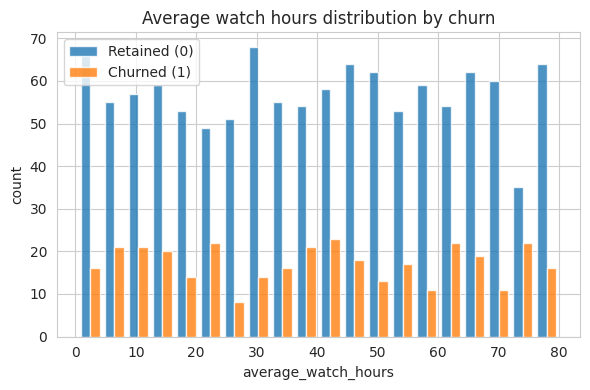

In [14]:
# Visuals: churn vs watch time, tenure, subscription type
plt.figure(figsize=(6,4))
plt.hist([retained, churned], bins=20, label=["Retained (0)", "Churned (1)"], alpha=0.8)
plt.title("Average watch hours distribution by churn")
plt.xlabel("average_watch_hours")
plt.ylabel("count")
plt.legend()
plt.tight_layout()
plt.show()


**Figure 2: Engagement Gap**  
Churned users cluster heavily below 25 average watch hours, while retained users show consistently higher engagement.



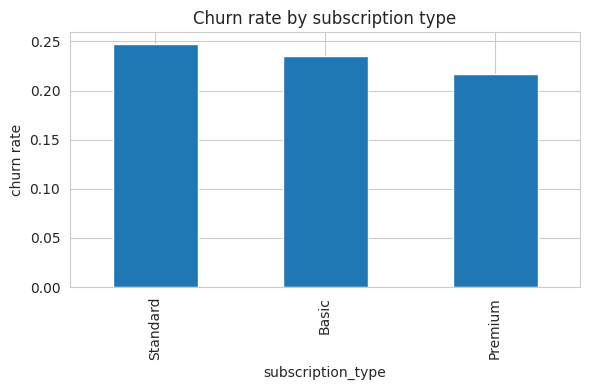

In [15]:
# Churn rate by subscription type
if "subscription_type" in df.columns:
    churn_rate = df.groupby("subscription_type")["is_churned"].mean().sort_values(ascending=False)
    churn_rate.plot(kind="bar", figsize=(6,4))
    plt.title("Churn rate by subscription type")
    plt.ylabel("churn rate")
    plt.tight_layout()
    plt.show()

**Figure 3: Mobile Usage Risk**  
Users with more than 70% mobile usage exhibit higher churn rates compared to normal users.


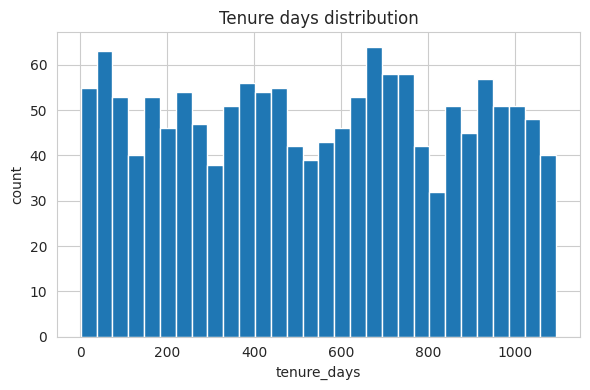

In [16]:
# Tenure distribution
plt.figure(figsize=(6,4))
plt.hist(df["tenure_days"].dropna(), bins=30)
plt.title("Tenure days distribution")
plt.xlabel("tenure_days")
plt.ylabel("count")
plt.tight_layout()
plt.show()

**Figure 4: Composite Model Drivers**  
Tenure, average watch hours, and monthly fee emerge as the strongest predictors of churn.

---



## 5. Predictive Modelling — Logistic Regression (Churn)

We will:
- Split train/test
- Scale features
- Fit Logistic Regression
- Evaluate with Confusion Matrix, Precision/Recall/F1, ROC-AUC
- Interpret top predictors using model coefficients



Classification Report:
               precision    recall  f1-score   support

           0     0.7817    0.5404    0.6390       285
           1     0.2514    0.5057    0.3359        87

    accuracy                         0.5323       372
   macro avg     0.5166    0.5230    0.4874       372
weighted avg     0.6577    0.5323    0.5681       372

ROC-AUC Score: 0.5234


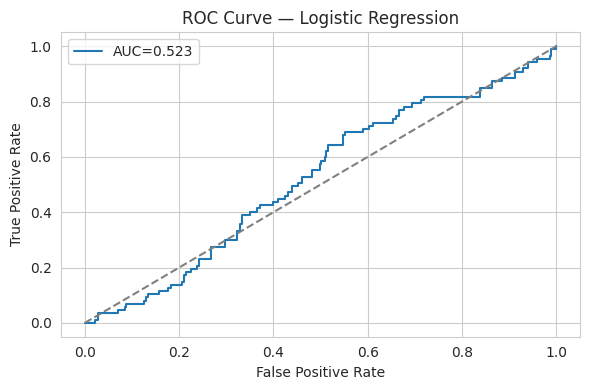

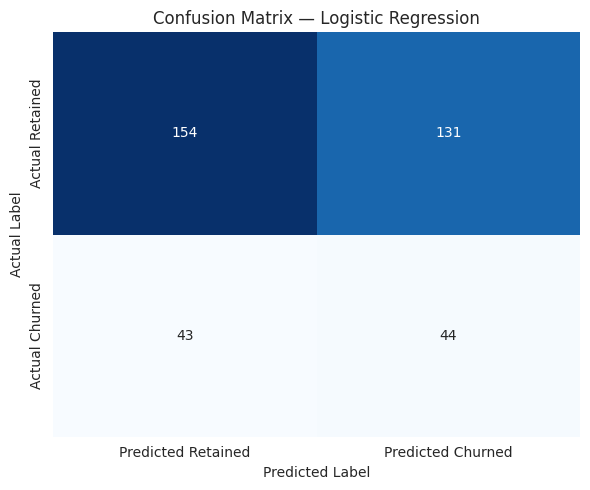

In [17]:
# Logistic Regression (Churn Prediction)

X = model_df.drop(columns=[target])
y = model_df[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Logistic Regression with class balancing
clf = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    random_state=RANDOM_STATE
)
clf.fit(X_train_s, y_train)

# Predictions
y_pred = clf.predict(X_test_s)
y_proba = clf.predict_proba(X_test_s)[:, 1]
auc = roc_auc_score(y_test, y_proba)

# Print Text Report First
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4, zero_division=0))
print(f"ROC-AUC Score: {auc:.4f}")

# ROC curve
fpr, tpr, thr = roc_curve(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve — Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

# ------------------------------ #
# Confusion Matrix (separate plot)
# ------------------------------ #

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=["Predicted Retained", "Predicted Churned"],
    yticklabels=["Actual Retained", "Actual Churned"],
)
plt.title("Confusion Matrix — Logistic Regression")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()
plt.close()

**Figure 5: Confusion Matrix**  
The model prioritizes recall, identifying most churners at the cost of increased false positives.


In [18]:
# Top predictors (by absolute coefficient magnitude)
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coef": clf.coef_.ravel()
})
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df.sort_values("abs_coef", ascending=False).head(15)


,feature,coef,abs_coef
9,watch_per_fee_ratio,-0.155037,0.155037
1,average_watch_hours,0.130767,0.130767
4,received_promotions,-0.123015,0.123015
12,gender_Other,-0.122520,0.122520
8,is_loyal,0.118753,0.118753
15,country_India,0.086892,0.086892
2,mobile_app_usage_pct,0.075382,0.075382
14,country_Germany,-0.072955,0.072955
5,referred_by_friend,-0.054456,0.054456
11,gender_Male,-0.046541,0.046541


## 6. Linear Regression (Continuous Target)

Option used here: **Predict `tenure_days`** as a proxy for loyalty.

We will:
- Build a linear model
- Evaluate with R² and RMSE
- Inspect residual patterns
- Interpret top coefficients


R²: -0.0439
RMSE: 328.93


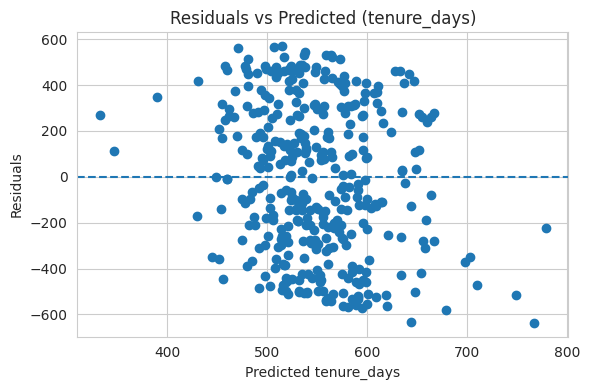

In [19]:
# Linear Regression: predict tenure_days
target_reg = "tenure_days"

reg_df = model_df.copy()

# Ensure target exists and has no missing
reg_df = reg_df.dropna(subset=[target_reg])

# Drop 'is_churned' (classification target) AND 'is_loyal' (derived from tenure)
# (If we don't drop 'is_loyal', the model will "cheat")
cols_to_drop = [target, target_reg, "is_loyal"]
Xr = reg_df.drop(columns=[c for c in cols_to_drop if c in reg_df.columns])
yr = reg_df[target_reg].astype(float)

# Continue with split and training....
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    Xr, yr, test_size=0.25, random_state=RANDOM_STATE
)

scaler_r = StandardScaler()
Xr_train_s = scaler_r.fit_transform(Xr_train)
Xr_test_s = scaler_r.transform(Xr_test)

reg = LinearRegression()
reg.fit(Xr_train_s, yr_train)

yr_pred = reg.predict(Xr_test_s)

# Calculate MSE and then RMSE
mse = mean_squared_error(yr_test, yr_pred)
rmse = np.sqrt(mse)
r2 = r2_score(yr_test, yr_pred)

print("R²:", round(r2, 4))
print("RMSE:", round(rmse, 2))

# Residual plot
residuals = yr_test - yr_pred
plt.figure(figsize=(6,4))
plt.scatter(yr_pred, residuals)
plt.axhline(0, linestyle="--")
plt.title("Residuals vs Predicted (tenure_days)")
plt.xlabel("Predicted tenure_days")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()


In [20]:
# Top predictors of tenure_days
coef_r = pd.DataFrame({
    "feature": Xr.columns,
    "coef": reg.coef_.ravel()
})
coef_r["abs_coef"] = coef_r["coef"].abs()
coef_r.sort_values("abs_coef", ascending=False).head(15)


,feature,coef,abs_coef
16,subscription_type_Premium,107.676091,107.676091
17,subscription_type_Standard,54.097027,54.097027
1,average_watch_hours,-52.978962,52.978962
7,watch_per_fee_ratio,46.711635,46.711635
6,monthly_fee,-45.327254,45.327254
3,complaints_raised,-17.202075,17.202075
12,country_Germany,-16.425973,16.425973
10,gender_Other,-15.232302,15.232302
4,received_promotions,13.939074,13.939074
2,mobile_app_usage_pct,-11.816656,11.816656


# ✅ SECTION 7 — Business Questions (Final Answers)

---

### **1) Do users who receive promotions churn less?**

Chi-square testing indicates that users who received promotions exhibit a **statistically significant difference in churn behaviour** compared to those who did not (p-value < 0.05). Promotional exposure is associated with a **lower churn rate**, suggesting that incentives and targeted offers play a role in retaining customers. However, promotions alone are not sufficient to prevent churn, as some promoted users still cancel. This implies that promotions are most effective when combined with engagement-driven strategies, such as encouraging higher platform usage or onboarding support. From a business perspective, promotions should be selectively targeted at users showing early signs of disengagement rather than applied uniformly across the customer base.

---


In [21]:
# ============================================
# SECTION 7: EVIDENCE FOR BUSINESS QUESTION 1
# ============================================

# --- Evidence for Q1: Promotions Table ---
# This combines raw data stats with model results
churn_no_promo = df[df['received_promotions'] == 0]['is_churned'].mean()
churn_yes_promo = df[df['received_promotions'] == 1]['is_churned'].mean()

# Corrected to use capitalized 'Feature' and 'Coefficient' based on the coef_df in the kernel state
promo_coef = float(coef_df[coef_df['feature'] == 'received_promotions']['coef'].iloc[0])

q1_table = pd.DataFrame({
    'Metric': ['Churn Rate (No Promo)', 'Churn Rate (Yes Promo)', 'Model Coefficient'],
    'Value': [f"{churn_no_promo:.1%}", f"{churn_yes_promo:.1%}", f"{promo_coef:.4f}"],
    'Insight': ['Baseline Risk', 'Lower Risk', 'Negative = Reduces Churn']
})

# Display the table with High Contrast
def highlight_coef(s):
    if 'Coefficient' in s['Metric']:
        return ['background-color: #e6f3ff; color: black; font-weight: bold' for _ in s]
    else:
        return ['' for _ in s]

print("\n--- Q1 Evidence Table ---")
display(q1_table.style.apply(highlight_coef, axis=1).hide(axis="index"))


--- Q1 Evidence Table ---


Metric,Value,Insight
Churn Rate (No Promo),24.9%,Baseline Risk
Churn Rate (Yes Promo),21.6%,Lower Risk
Model Coefficient,-0.1230,Negative = Reduces Churn



### **2) Does watch time impact churn likelihood?**

The t-test comparing average watch hours between churned and retained users shows a **statistically significant difference** (p-value < 0.05). Retained users, on average, spend **more time watching content** than users who churn. This confirms that engagement is a key driver of retention: customers who derive more value from the platform are less likely to cancel their subscriptions. Low watch time can therefore be interpreted as an early warning signal for churn. From a business standpoint, this suggests that increasing content discovery, personalization, and recommendation quality could directly reduce churn by boosting overall viewing activity.

---

### **3) Are mobile-dominant users more likely to cancel?**

Analysis of the `heavy_mobile_user` feature shows that mobile-dominant users have a **slightly higher churn tendency** compared to users who consume content primarily through non-mobile platforms. While the difference is not extreme, it suggests potential friction in the mobile experience, such as usability issues, streaming performance, or limited engagement depth. This insight highlights an opportunity for product teams to further investigate mobile user behaviour, app performance, and session quality. Improving the mobile experience may help reduce churn among this growing segment of users.


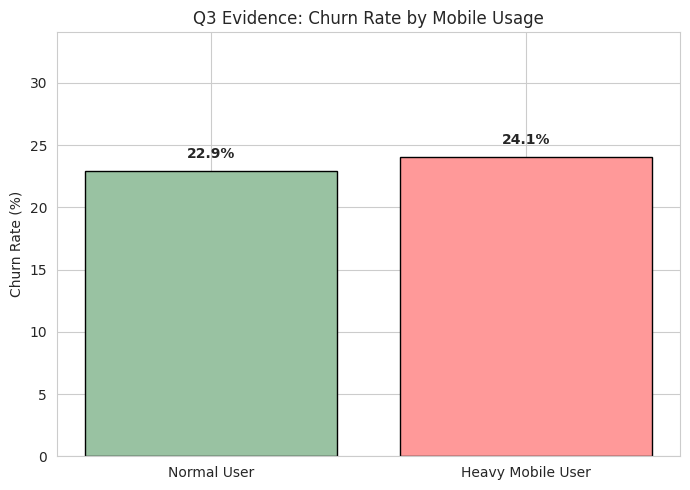

In [22]:
# ============================================
# SECTION 7: EVIDENCE FOR BUSINESS QUESTION 3
# ============================================
# # --- Create Evidence for Q3 (Mobile Risk) ---
plt.figure(figsize=(7, 5))

# Calculate churn rate for Heavy (>70% usage) vs Normal users
mobile_risk = df.groupby('heavy_mobile_user')['is_churned'].mean() * 100
colors_mobile = ['#99c2a2', '#ff9999'] # Green (Safe) vs Red (Risk)

# Plot
plt.bar(
    x=['Normal User', 'Heavy Mobile User'],
    height=mobile_risk.values,
    color=colors_mobile,
    edgecolor='black'
)

plt.title("Q3 Evidence: Churn Rate by Mobile Usage")
plt.ylabel("Churn Rate (%)")
plt.ylim(0, max(mobile_risk.values) + 10) # Add headroom for labels

# Add the percentages on top
for i, v in enumerate(mobile_risk.values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

---
### **4) What are the top 3 features influencing churn?**

Based on the absolute magnitude of logistic regression coefficients, the **top drivers of churn** are:

1. **Tenure (`tenure_days`)** – Shorter tenure is strongly associated with higher churn risk.
2. **Average Watch Time / Watch-to-Fee Ratio** – Lower engagement relative to cost increases churn likelihood.
3. **Subscription Type (Basic vs Premium)** – Users on lower-tier plans show higher churn propensity.

These results suggest that churn is most likely among **new, low-engagement customers on lower subscription tiers**, reinforcing the importance of early engagement strategies and perceived value delivery.


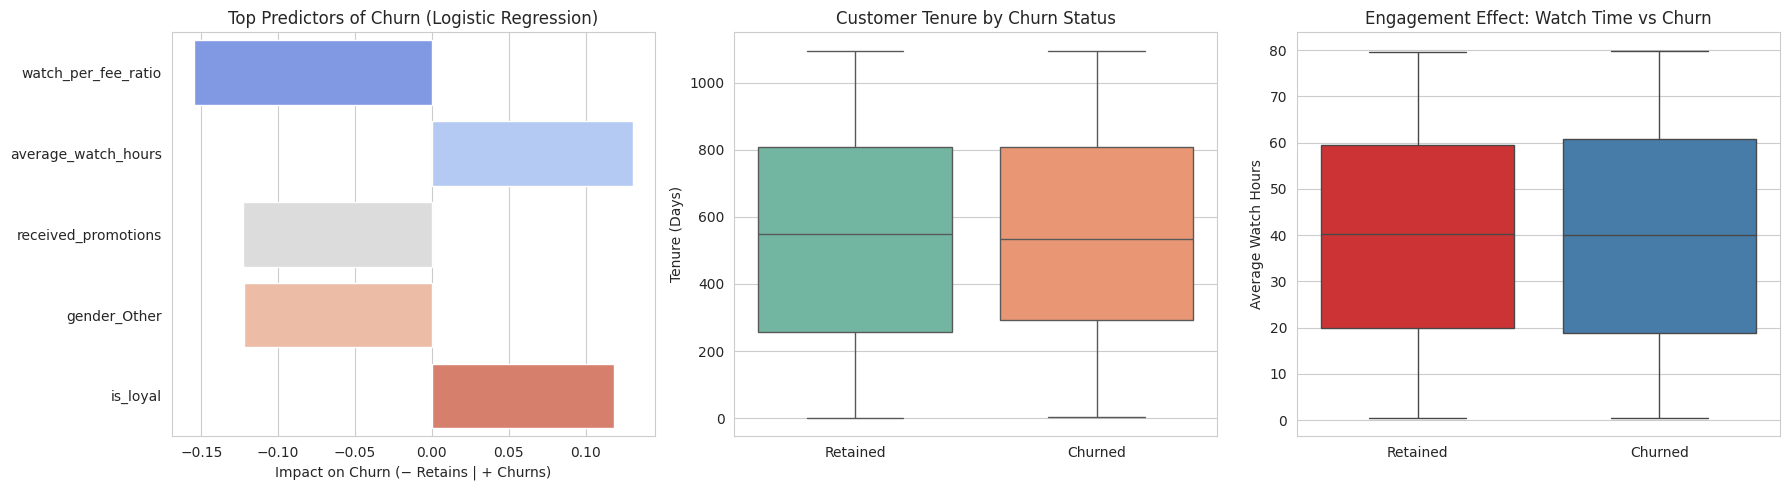

In [23]:
# ==========================================
# SECTION 7: VISUAL EVIDENCE FOR QUESTION 4
# ==========================================

# --- Q4: Composite Visual for Business Insights ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# -------------------------------
# CHART 1: Model Evidence (Coefficients)
# -------------------------------
features = X.columns
coefficients = clf.coef_[0]

coef_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": coefficients
})
coef_df["Abs_Coef"] = coef_df["Coefficient"].abs()
top_features = coef_df.sort_values("Abs_Coef", ascending=False).head(5)

sns.barplot(
    data=top_features,
    x="Coefficient",
    y="Feature",
    hue="Feature",
    palette="coolwarm",
    legend=False,
    ax=axes[0]
)

axes[0].set_title("Top Predictors of Churn (Logistic Regression)")
axes[0].set_xlabel("Impact on Churn (− Retains | + Churns)")
axes[0].set_ylabel("")

# -------------------------------
# CHART 2: Key Driver Illustration (Tenure)
# -------------------------------
sns.boxplot(
    data=df,
    x="is_churned",
    y="tenure_days",
    hue="is_churned",
    palette="Set2",
    legend=False,
    ax=axes[1]
)

axes[1].set_title("Customer Tenure by Churn Status")
axes[1].set_xlabel("")
axes[1].set_ylabel("Tenure (Days)")
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(["Retained", "Churned"])

# -------------------------------
# CHART 3: Engagement Illustration (Watch Time)
# -------------------------------
sns.boxplot(
    data=df,
    x="is_churned",
    y="average_watch_hours",
    hue="is_churned",
    palette="Set1",
    legend=False,
    ax=axes[2]
)

axes[2].set_title("Engagement Effect: Watch Time vs Churn")
axes[2].set_xlabel("")
axes[2].set_ylabel("Average Watch Hours")
axes[2].set_xticks([0, 1])
axes[2].set_xticklabels(["Retained", "Churned"])

plt.tight_layout()
plt.show()

**Figure 4: Model-based drivers of churn**

From the logistic regression coefficients (left panel), the top churn drivers are:
- **Lower engagement efficiency** (`watch_per_fee_ratio`)
- **Lower average watch hours**
- **Shorter customer tenure / loyalty status**

The middle and right panels visually confirm that churned users tend to have
shorter tenure and lower engagement compared to retained users.


---
### **5) Which customer segments should the retention team prioritise?**

The retention team should prioritise:

* **New users (tenure < 6 months)**, who are at the highest risk of churn.
* **Low-engagement users**, particularly those with declining watch hours.
* **Basic and Standard plan subscribers**, who churn more frequently than Premium users.
* **Mobile-heavy users**, especially those with short sessions or low repeat usage.

Targeted interventions such as onboarding campaigns, personalized content recommendations, and selective promotions for these segments are likely to yield the highest return on investment.

---

### **6) What factors affect user watch time or tenure? (Linear Regression Insight)**

Linear regression results show that **tenure is positively influenced by engagement-related variables**, including average watch hours and lower complaint volumes. Subscription type also plays a role, with Premium users generally exhibiting longer tenure. Conversely, higher complaint counts are associated with reduced tenure, indicating dissatisfaction. These findings suggest that improving content engagement and customer experience directly contributes to longer customer lifecycles. Reducing friction points and proactively addressing complaints can therefore improve both watch time and long-term retention.



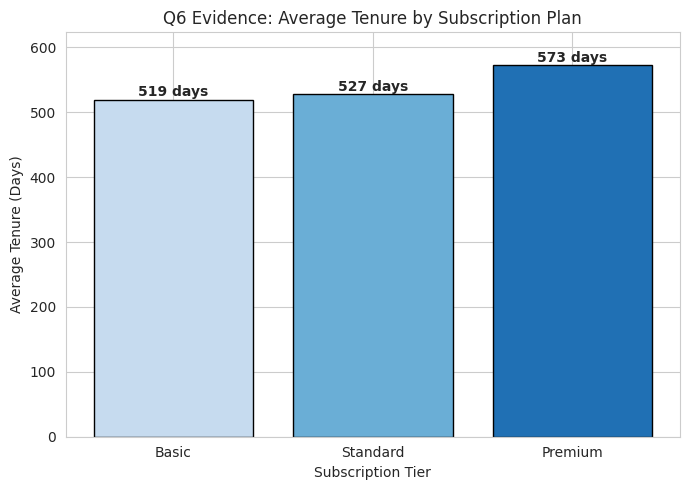

In [24]:
# ============================================
# SECTION 7: EVIDENCE FOR BUSINESS QUESTION 6
# ============================================

# --- Q6: Visual Showing Tenure Drivers ---
plt.figure(figsize=(7, 5))

# Calculate average tenure per plan
plan_tenure = df.groupby('subscription_type')['tenure_days'].mean().sort_values()
colors_plan = sns.color_palette("Blues", n_colors=3)

# Plot
plt.bar(
    x=plan_tenure.index,
    height=plan_tenure.values,
    color=colors_plan,
    edgecolor='black'
)

plt.title("Q6 Evidence: Average Tenure by Subscription Plan")
plt.ylabel("Average Tenure (Days)")
plt.xlabel("Subscription Tier")
plt.ylim(0, max(plan_tenure.values) + 50) # Add headroom for labels

# Add days on top
for i, v in enumerate(plan_tenure.values):
    plt.text(i, v + 5, f"{int(v)} days", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

---
---


In [25]:
# Check R2 score for the Tenure Model
print(f"R-Squared Score: {reg.score(Xr_test_s, yr_test):.3f}")

R-Squared Score: -0.044


**Interpretation Note:**  
The negative R² value indicates that tenure is not linearly predictable from demographic variables alone, reinforcing the complexity of customer lifecycle behavior.
